In [25]:
#Download data

import yfinance as yf

df =yf.Ticker('AAPL').history(start='2010-01-01', period='1D')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00-05:00,6.487648,6.520173,6.455731,6.505279,493729600,0.0,0.0
2010-01-05 00:00:00-05:00,6.523215,6.553308,6.482179,6.516528,601904800,0.0,0.0
2010-01-06 00:00:00-05:00,6.516527,6.542365,6.406186,6.412873,552160000,0.0,0.0
2010-01-07 00:00:00-05:00,6.436583,6.444182,6.354510,6.401018,477131200,0.0,0.0
2010-01-08 00:00:00-05:00,6.392506,6.444182,6.354815,6.443573,447610800,0.0,0.0
...,...,...,...,...,...,...,...
2023-02-27 00:00:00-05:00,147.710007,149.169998,147.449997,147.919998,44998500,0.0,0.0
2023-02-28 00:00:00-05:00,147.050003,149.080002,146.830002,147.410004,50547000,0.0,0.0
2023-03-01 00:00:00-05:00,146.830002,147.229996,145.009995,145.309998,55479000,0.0,0.0


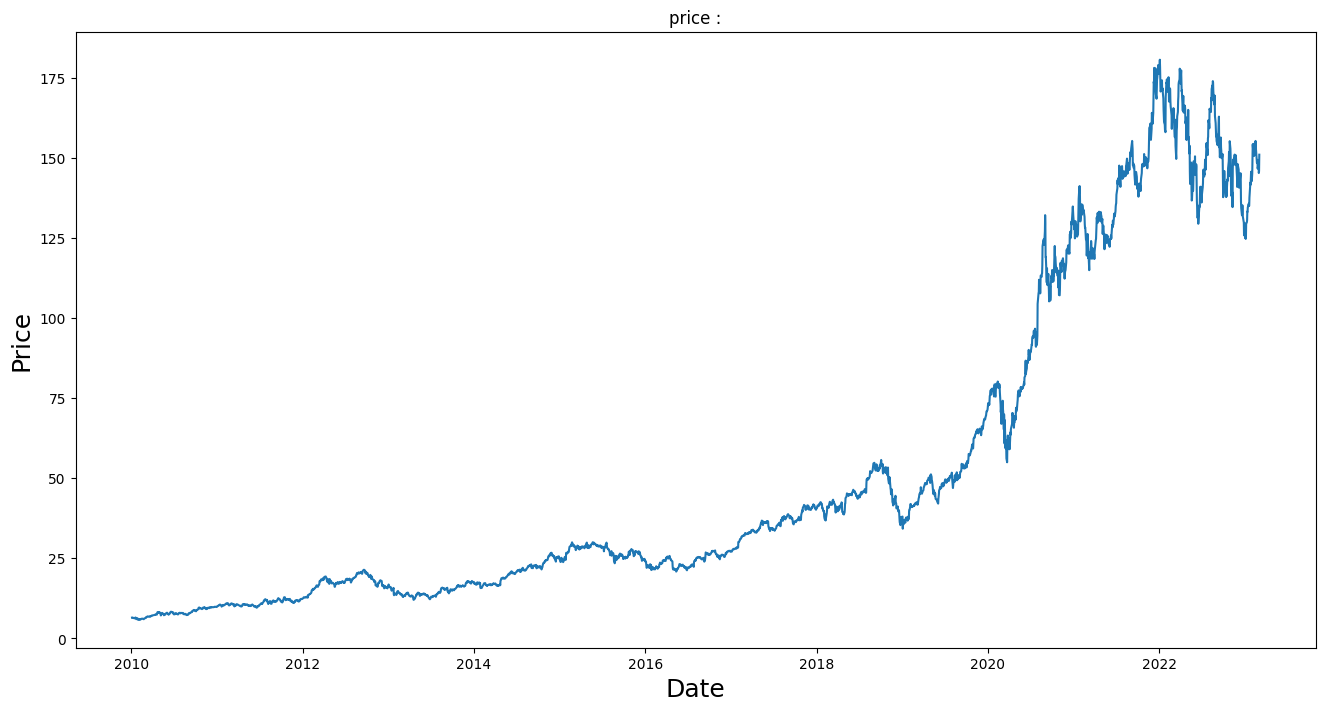

In [26]:
#plot first data
from matplotlib import pyplot as plt
plt.figure(figsize=(16,8))
plt.title('price :')
plt.plot(df['Close'])
plt.xlabel('Date' , fontsize = 18)
plt.ylabel('Price' , fontsize = 18)
plt.show()



In [27]:
#filter close data
import math
price = df.filter(['Close'])
price = price.values
volume = df.filter(['Volume'])
volume = volume.values
price.shape

(3314, 1)

In [28]:
#Scale data
import numpy as np

add_volume = False if volume.max() == 0 else True


price_scaled =((price - price.min())/(price.max()- price.min()))
volume_scaled = ((volume - volume.min())/(volume.max()- volume.min())) if add_volume else np.array([])


train_len = math.ceil(len(price_scaled) * .8)
print('max = ' + str(price_scaled.max()) + ' min = '+ str(price_scaled.min()) )


max = 1.0 min = 0.0


In [29]:
#all data prepare
data = []
for index , pr in enumerate(price_scaled):
    row =  np.array([pr[0], volume_scaled[index][0]]) if add_volume else np.array([pr[0]])
    data.append(row)
    


data = np.array(data)
data





array([[0.00381774, 0.24841975],
       [0.00388208, 0.30702582],
       [0.00328925, 0.28007558],
       ...,
       [0.79768568, 0.01098877],
       [0.80111731, 0.00923295],
       [0.83040017, 0.01921799]])

In [30]:
#Build model
from keras.models import  Sequential
from keras.layers import Dense,LSTM,Dropout

count_train = 100

model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape = (count_train, data.shape[1]) ))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam' , loss="mse")



In [31]:
#Prepare train data
train_data = data[:train_len, :]
x_train = []
y_train = []



for i in range(count_train, len(train_data)):
    x_train.append(train_data[i-count_train:i, :])
    y_train.append(train_data[ i, 0])


x_train , y_train = np.array(x_train) , np.array(y_train)

# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],  x_train.shape[2]))

print(x_train.shape)
print(y_train.shape)



(2552, 100, 2)
(2552,)


In [32]:
#Train model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2552/2552 [==============================] - 67s 26ms/step - loss: 2.6581e-04


In [33]:
#Prepare test data

test_data = data[train_len-count_train:, :]
x_test = []
y_test = price_scaled[train_len:,:]



for i in range(count_train, len(test_data)):
    x_test.append(test_data[i-count_train:i, :])

x_test, y_test = np.array(x_test) , np.array(y_test)

y_test.shape

(662, 1)

In [34]:
#Predict data
predictions = model.predict(x_test)


def correction(val):
    return val * (price.max() - price.min())+price.min()

last_test = 0
good = 0
bad = 0
profit = 0
for index , pr in enumerate(predictions):
    if index !=0:
        if(   0 <= ( pr[0] - last_test) * ( y_test[index]  - last_test) ):
            good = good +1
            profit = profit +abs ( y_test[index]  - last_test)
        else:
            bad = bad + 1
            profit = profit - abs ( y_test[index]  - last_test)
    last_test = y_test[index]
 

print(f'acc = {round(good/(good+bad)*100,2)}%')
profit = correction(profit)
print(f'profit = {profit}')
print('_________________________')
print('Predictions')
print(correction( predictions)[:12])
print('Valid')
print(correction( y_test)[:12])


21/21 [==============================] - 1s 24ms/step
acc = 51.89%
profit = [78.26578569]
_________________________
Predictions
[[93.600975]
 [93.89761 ]
 [94.42592 ]
 [94.59864 ]
 [94.77327 ]
 [93.84579 ]
 [92.95676 ]
 [92.62578 ]
 [92.084   ]
 [91.93263 ]
 [91.89575 ]
 [93.24304 ]]
Valid
[[ 94.70530701]
 [ 96.70114136]
 [ 95.36650085]
 [ 95.63440704]
 [ 91.28146362]
 [ 91.05534363]
 [ 93.21337128]
 [ 91.68211365]
 [ 93.43949127]
 [ 94.57013702]
 [104.47055054]
 [107.10297394]]


/tmp/ipykernel_12747/1314093856.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = correction( predictions)


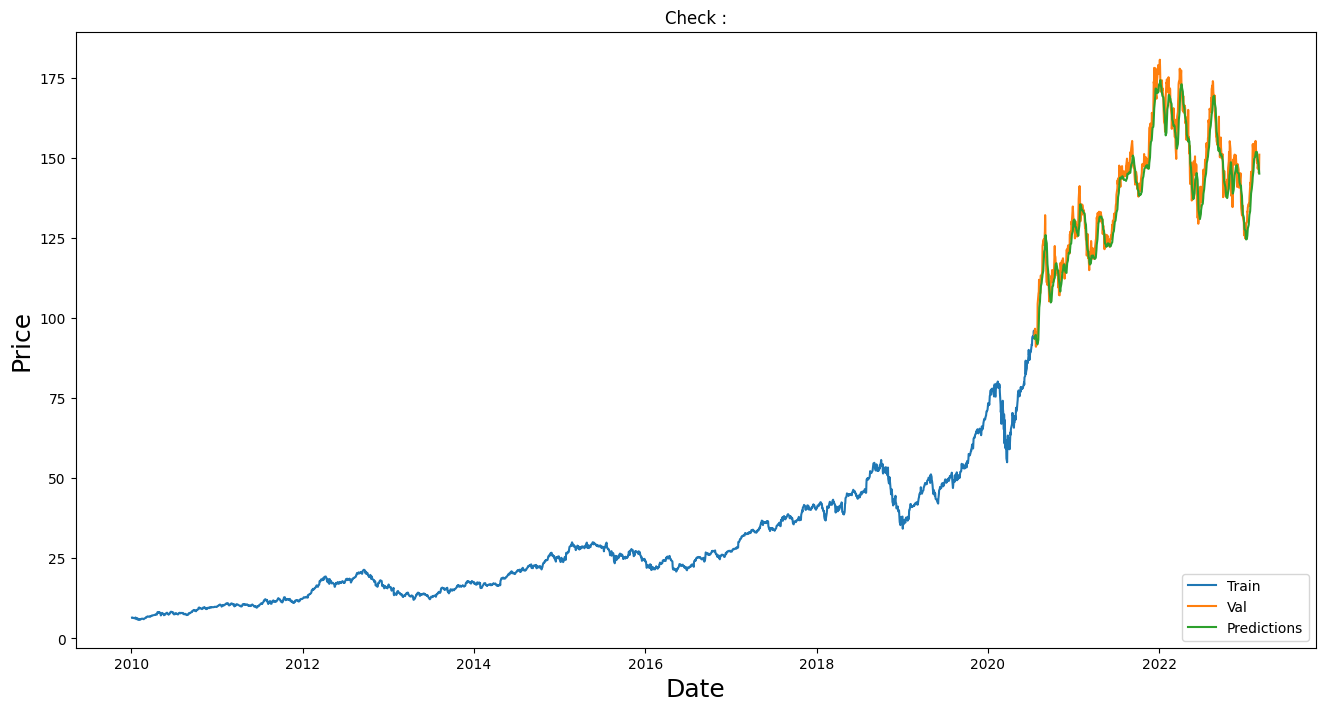

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Predictions
Date,,,,,,,,
2020-07-17 00:00:00-04:00,95.354196,95.511498,94.226014,94.705307,92186800,0.0,0.0,93.600975
2020-07-20 00:00:00-04:00,94.793816,96.841243,94.444791,96.701141,90318000,0.0,0.0,93.897614
2020-07-21 00:00:00-04:00,97.502416,97.578610,95.113338,95.366501,103433200,0.0,0.0,94.425919
2020-07-22 00:00:00-04:00,95.064173,96.325076,94.975692,95.634407,89001600,0.0,0.0,94.598640
2020-07-23 00:00:00-04:00,95.364031,95.442685,90.460526,91.281464,197004400,0.0,0.0,94.773270
...,...,...,...,...,...,...,...,...
2023-02-27 00:00:00-05:00,147.710007,149.169998,147.449997,147.919998,44998500,0.0,0.0,148.455902
2023-02-28 00:00:00-05:00,147.050003,149.080002,146.830002,147.410004,50547000,0.0,0.0,147.649323
2023-03-01 00:00:00-05:00,146.830002,147.229996,145.009995,145.309998,55479000,0.0,0.0,146.860550


In [35]:
#PLOT DATA
train = df[:train_len]
valid = df[train_len:]
valid['Predictions'] = correction( predictions)

plt.figure(figsize=(16,8))
plt.title('Check :')

plt.xlabel('Date' , fontsize = 18)
plt.ylabel('Price' , fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close' , 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc= 'lower right')
plt.show()


valid